If you want to view this as a slideshow, press the bar chart button <button class="btn btn-default" data-jupyter-action="RISE:slideshow"><i class="fa-bar-chart fa"></i></button> above.  If it doesn't appear, you'll need to install the [RISE slideshow extension](https://rise.readthedocs.io/en/stable/).

To save as PDF, run
```bash
jupyter nbconvert --to slides outline.ipynb --template slide_reveal_custom.tpl --post serve
```
This will open a new browser tab.  Remove any `#` from and add `?print-pdf` to the end of the URL, print, select Landscape, and save as PDF.

# The SXS Catalog of Simulations

### Mike Boyle

# Outline

* Simulations
  * SpEC
  * The numbers
  * Post-processing
* The data
  * What's included
  * How to get it
  * Formats
  * Problems
  * Solutions
* Software

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0123v4/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5


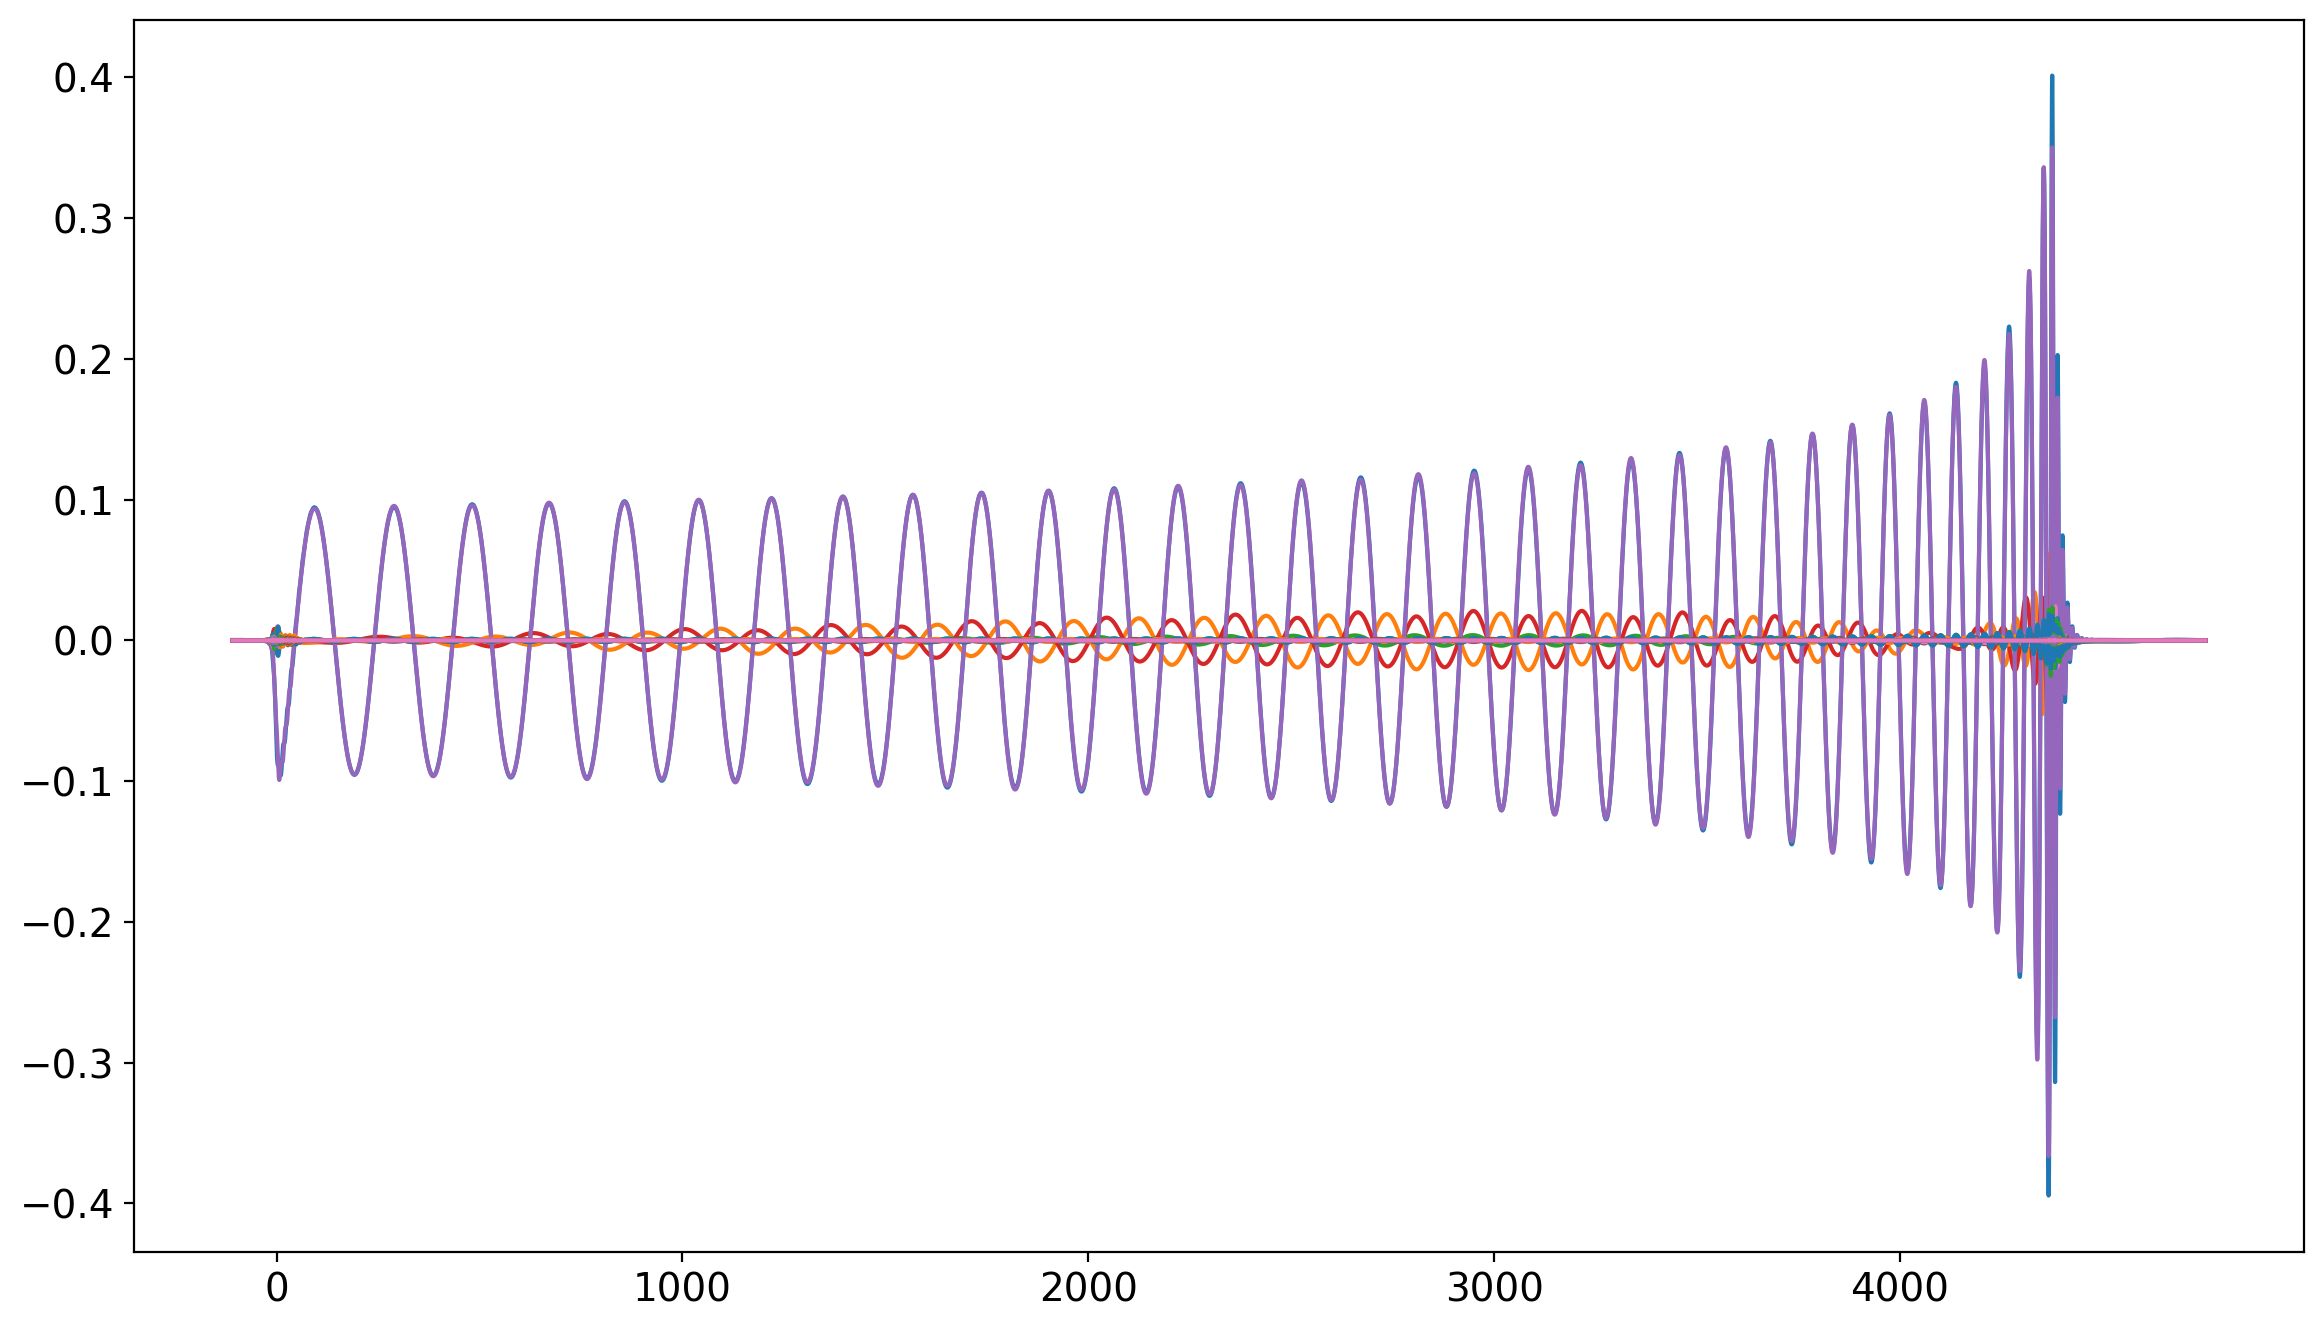

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sxs

waveform = sxs.load("SXS:BBH:0123/Lev/rhOverM", extrapolation_order=2, download=True)
plt.plot(waveform.t, waveform.data.real);

# SpEC

  * Initial data solves extended conformal thin sandwich equations
  * Iterate to reduce eccentricity if desired
  * Multi-domain spectral methods
  * First-order generalized harmonic with constraint damping
  * Adaptive mesh refinement
  * Constraint-preserving boundary conditions
  
  
  
  https://arxiv.org/abs/1904.04831

# Simulations

* 2 NSNS
* 7 BHNS
* 2019 BBH
  * mass ratios between 1 and 10
  * spin magnitudes up to 0.998
  * 1426 precessing simulations
  * typically ~19 orbits

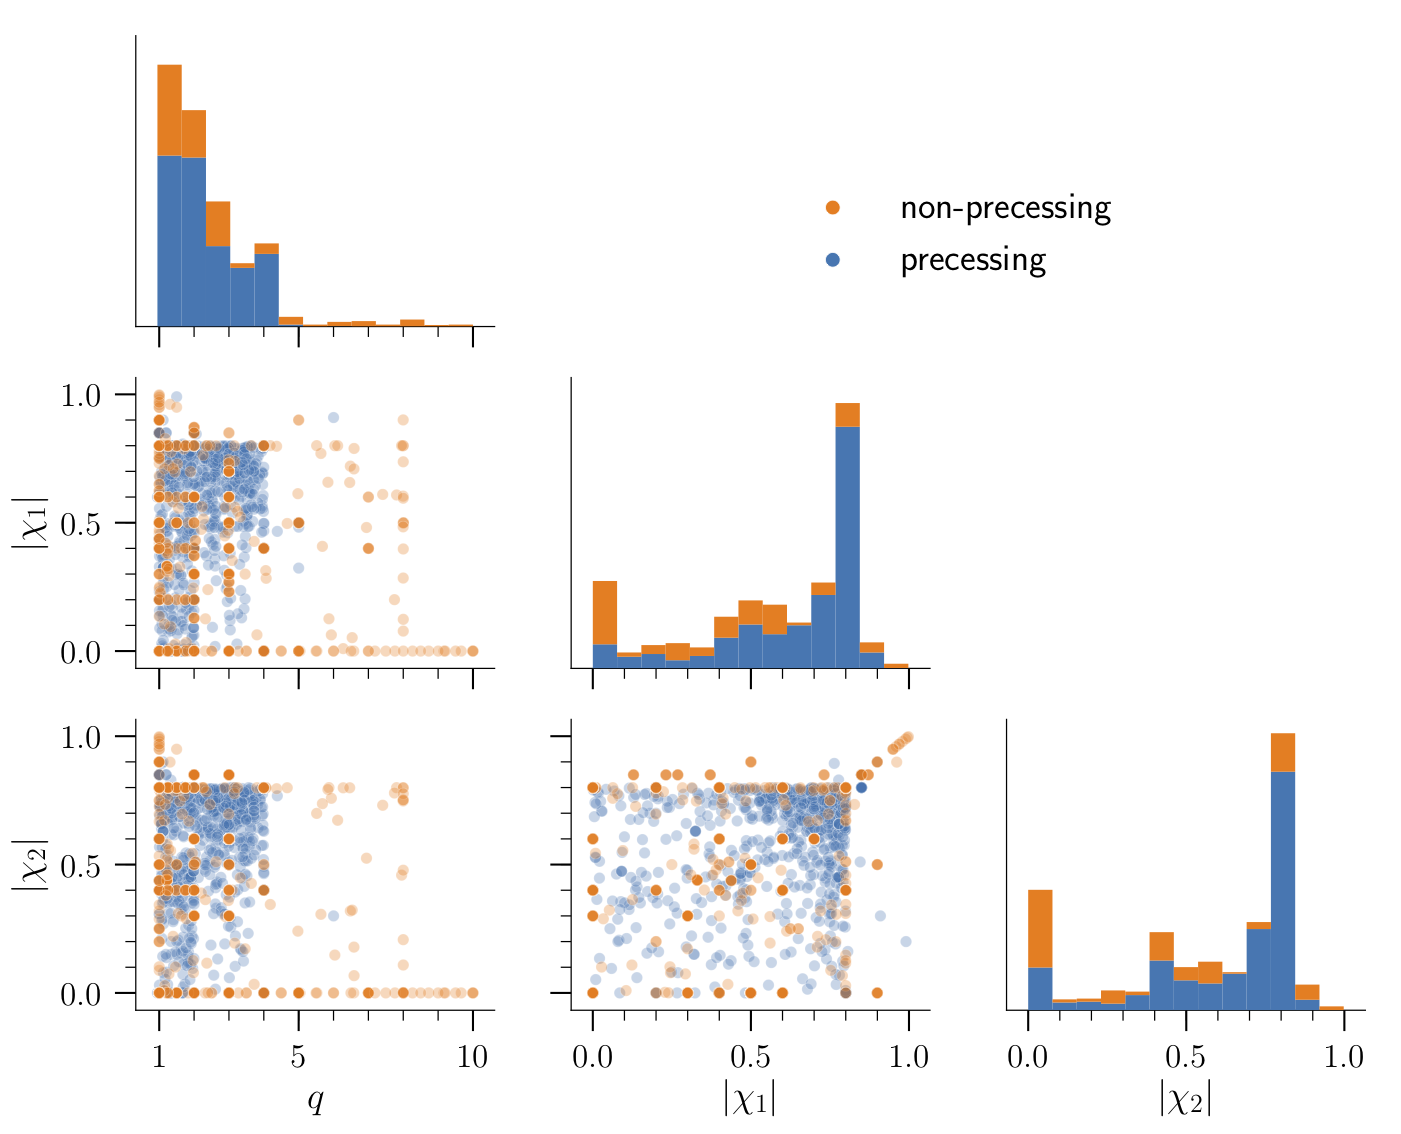

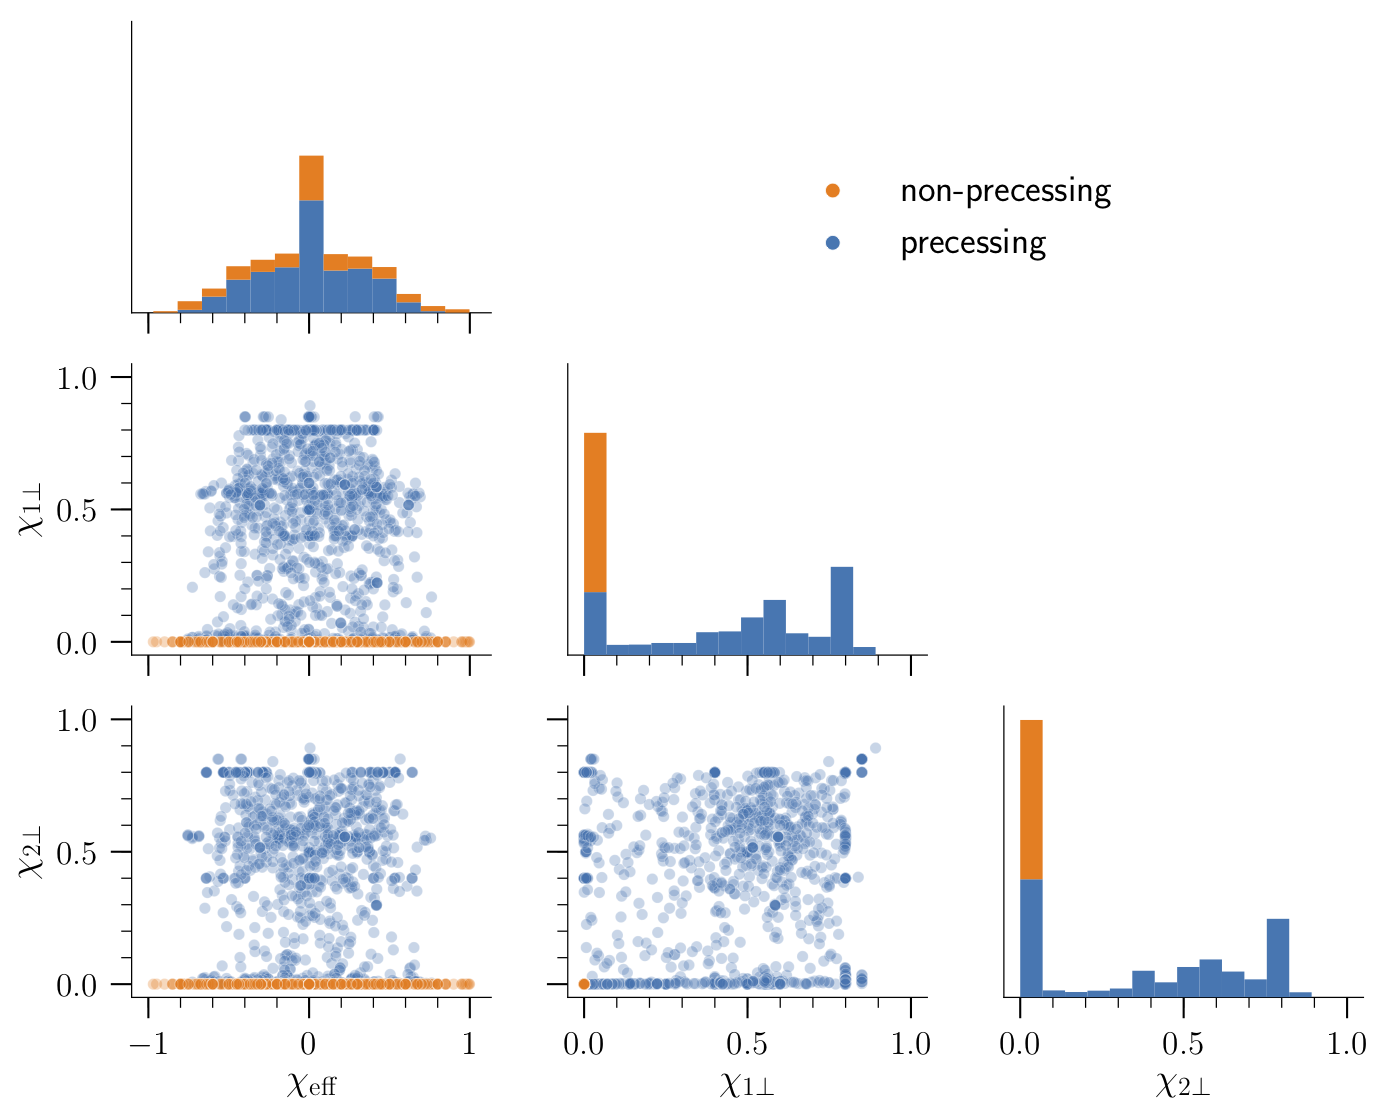

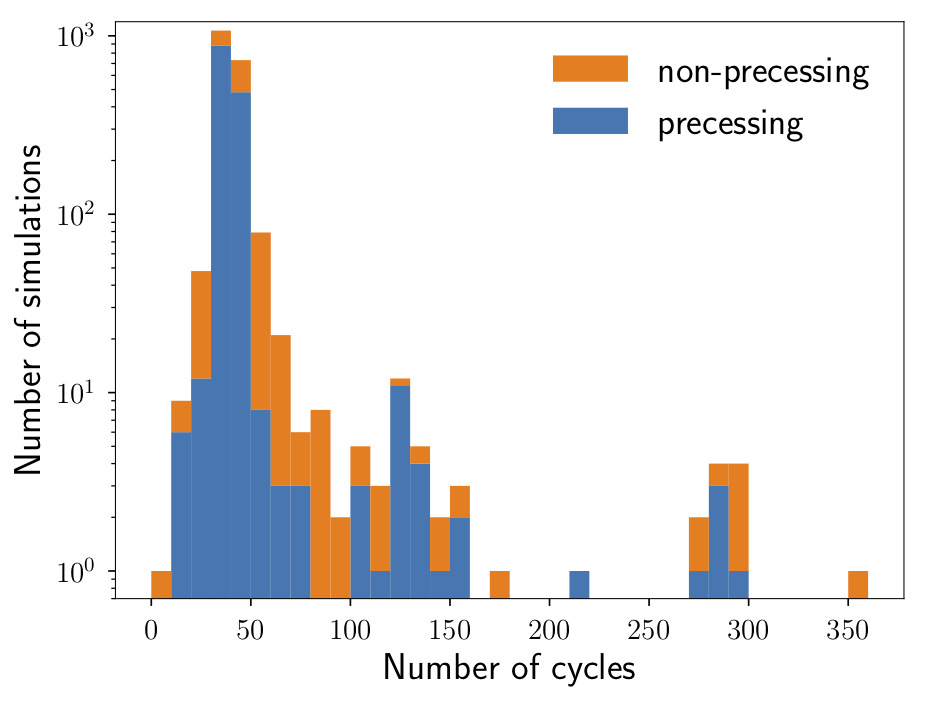

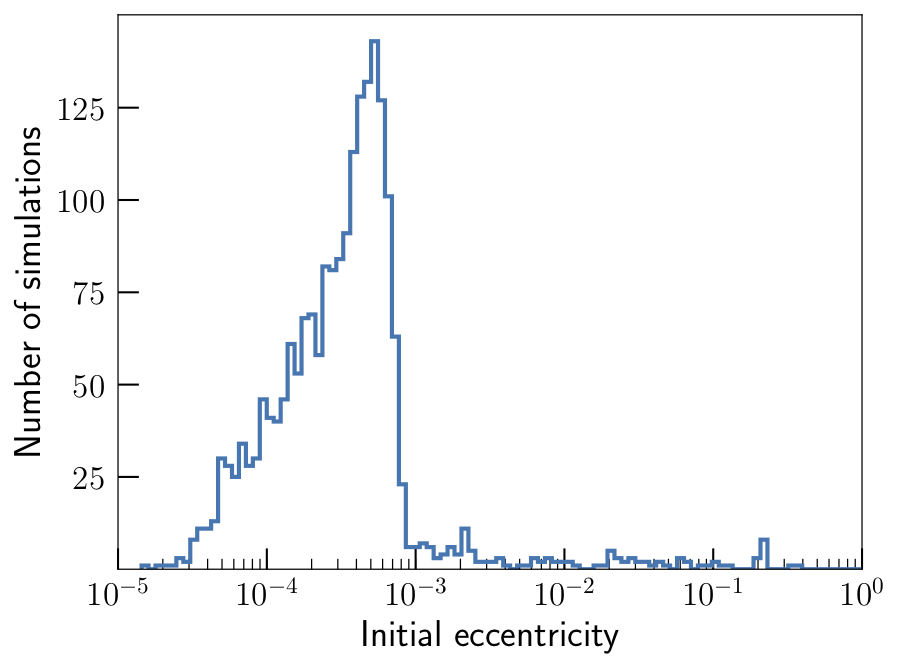

# Data extracted during the runs

* Horizon information
  * Coordinate trajectories
  * Areal (irreducible) mass
  * Christodoulou mass
  * Spins
* On a series of ~24 spheres between ~100$M$ and outer boundary
  * RWZ $h$ modes
  * $\Psi_4$ modes
  * Surface area
  * Average lapse
* (Data for CCE)

# Post-processing

* (CCE, soon)
* Extrapolation of $\Psi_4$ and $h$
* Center-of-mass correction

# Extrapolation

* Define corrected retarded time on each sphere
\begin{equation*}
    u_{i,j} = \int_{0}^{T_{i}} \sqrt{ \frac{-1/g_{j}^{TT}(T)} {1 - 2 M_{\mathrm{ADM}} / R_{j}(T)} } dT - R_{j}(T_{i}) - 2 M_{\mathrm{ADM}} \ln \left[ \frac{R_{j}(T_{i})}{2 M_{\mathrm{ADM}}} - 1 \right],
\end{equation*}

* Fit the waveforms with a simple
\begin{equation*}
  f(u, r) \approx \sum_{j=0}^N \frac{f_{(j)}(u)} {r^j}
\end{equation*}
* Extrapolated waveform is $f_{(0)}(u)$

# CoM correction

* "Gauge-invariant waveforms" 🙄
* Displacements around 0.1M show up as big wiggles
* General BMS transformations allowed
* We just use boost and translation
* Even worse, we just use the horizon trajectories


https://arxiv.org/abs/1509.00862

https://arxiv.org/abs/1904.04842

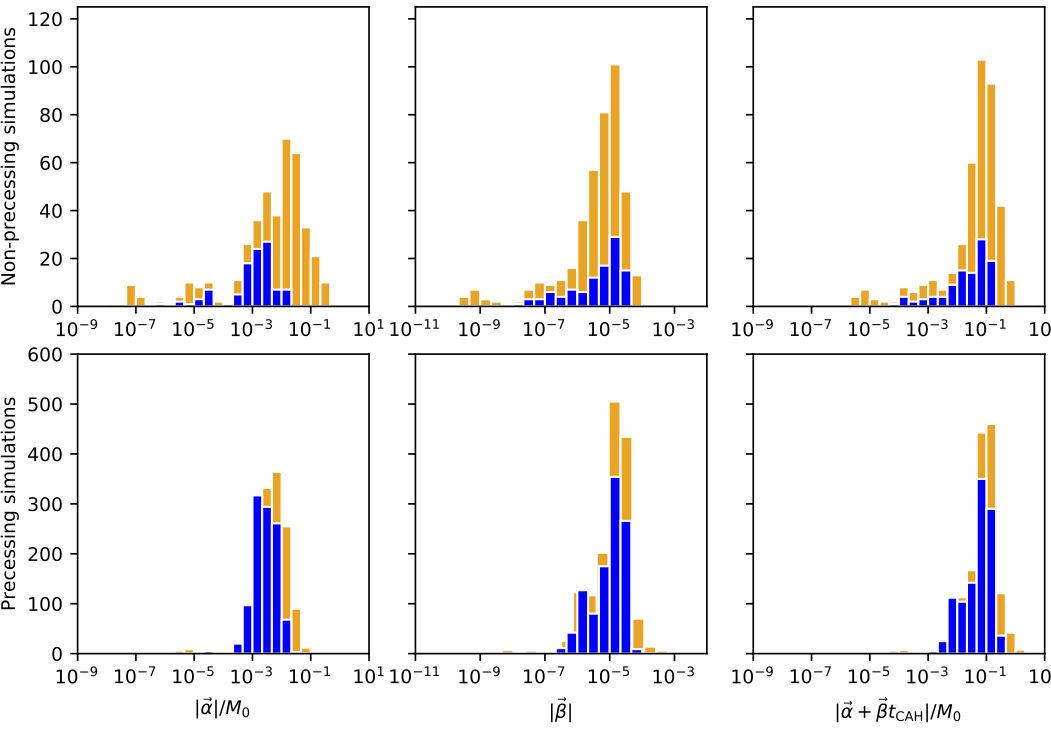

# The problem

* Total catalog is ~16 TB
* Extrapolated waveform files currently average 95 MB each
* Users who want one waveform from each simulation need ~200 GB
* This is accelerating

# The solutions

* Eliminate redundant time data — factor of ~1.45 reduction
* Reduce the number of files — factor of ~8 reduction
  * Eliminate finite-radius files
  * Eliminate non-CoM files
* Store each file more efficiently — factor of ~4 reduction

* Total catalog size falls to ~500 GB
* Typical user needs ~10 GB

# Corotating frame

* Defined as rotating frame that minimizes time dependence of modes
* Compute angular velocity of this frame by solving
\begin{equation}
  \langle h | L\, L \cdot \vec{\omega} | h \rangle = -\langle h | L\, \partial_t | h \rangle
\end{equation}
* The integrate the angular velocity to find a frame
* Constant of integration $\to$ align $z$ with dominant eigenvector of $\langle h | L\, L | h \rangle$


https://arxiv.org/abs/1302.2919

# Conjugate-pair mode representation

* $h_{\ell, m}$ and $h_{\ell, -m}$ are at least somewhat redundant in corotating frame
* Define
\begin{align*}
  s_{\ell, m} &= \frac{h_{\ell, m} + \bar{h}_{\ell, -m}}{\sqrt{2}} \\ \\
  d_{\ell, m} &= \frac{h_{\ell, m} - \bar{h}_{\ell, -m}}{\sqrt{2}}
\end{align*}
* One of these will be zero (non-precessing systems) or small (otherwise)
* Thus they compress well
* Store

    [$d_{2,2}$, $d_{2,1}$, $h_{2,0}$, $s_{2,1}$, $s_{2,2}$, $d_{3,3}$, $d_{3,2}$, $d_{3,1}$, $h_{3,0}$, $s_{3,1}$, $s_{3,2}$, $s_{3,3}$, ... ]

# Truncation

Zero out bits that affect norm at level below some chosen tolerance
* Only non-exact step
* Choose the *relative* tolerance `tol`
* Defines the *absolute* tolerance `tol * norm(data)` as function of time
* Drop bits at lower significance from conjugate-pair modes

<br /><br />

```python
def truncate(data, n_modes, tol=1e-10):
    tol /= sqrt(n_modes)  # Distribute ~evenly among all modes
    abs_tol = tol * norm(data, axis=1)
    power_of_2 = 2 ** (floor(-log2(abs_tol)))  # 1 / (largest power of 2 <= abs_tol)
    return round(data * power_of_2) / power_of_2
```

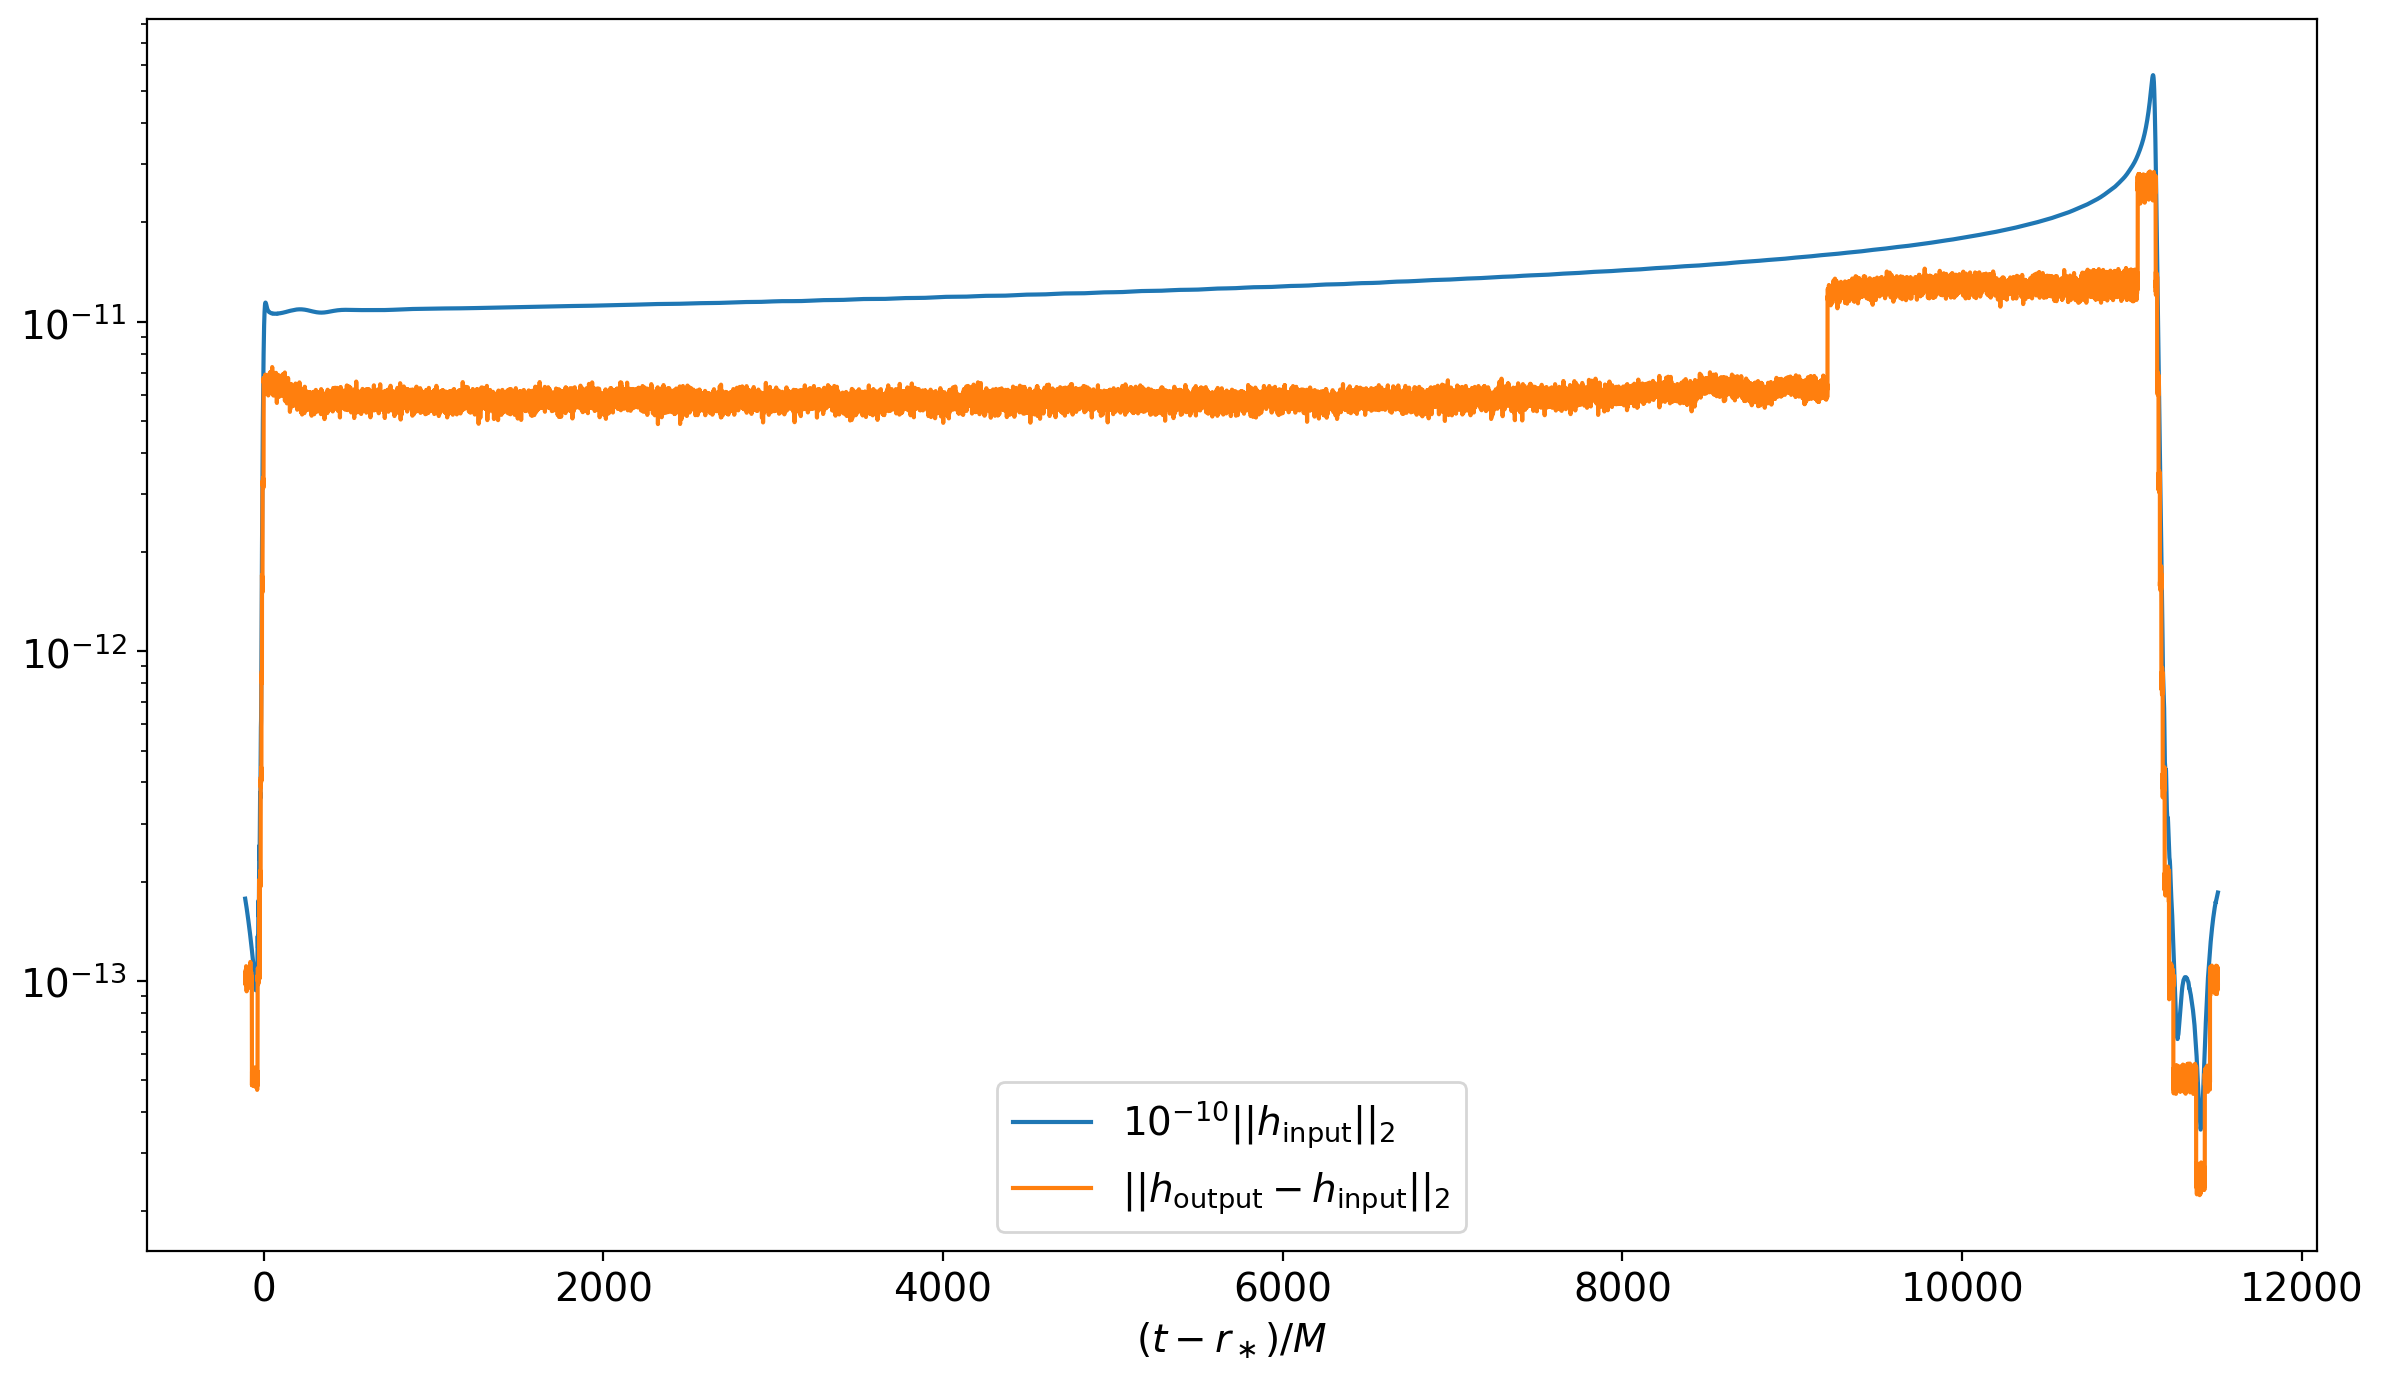

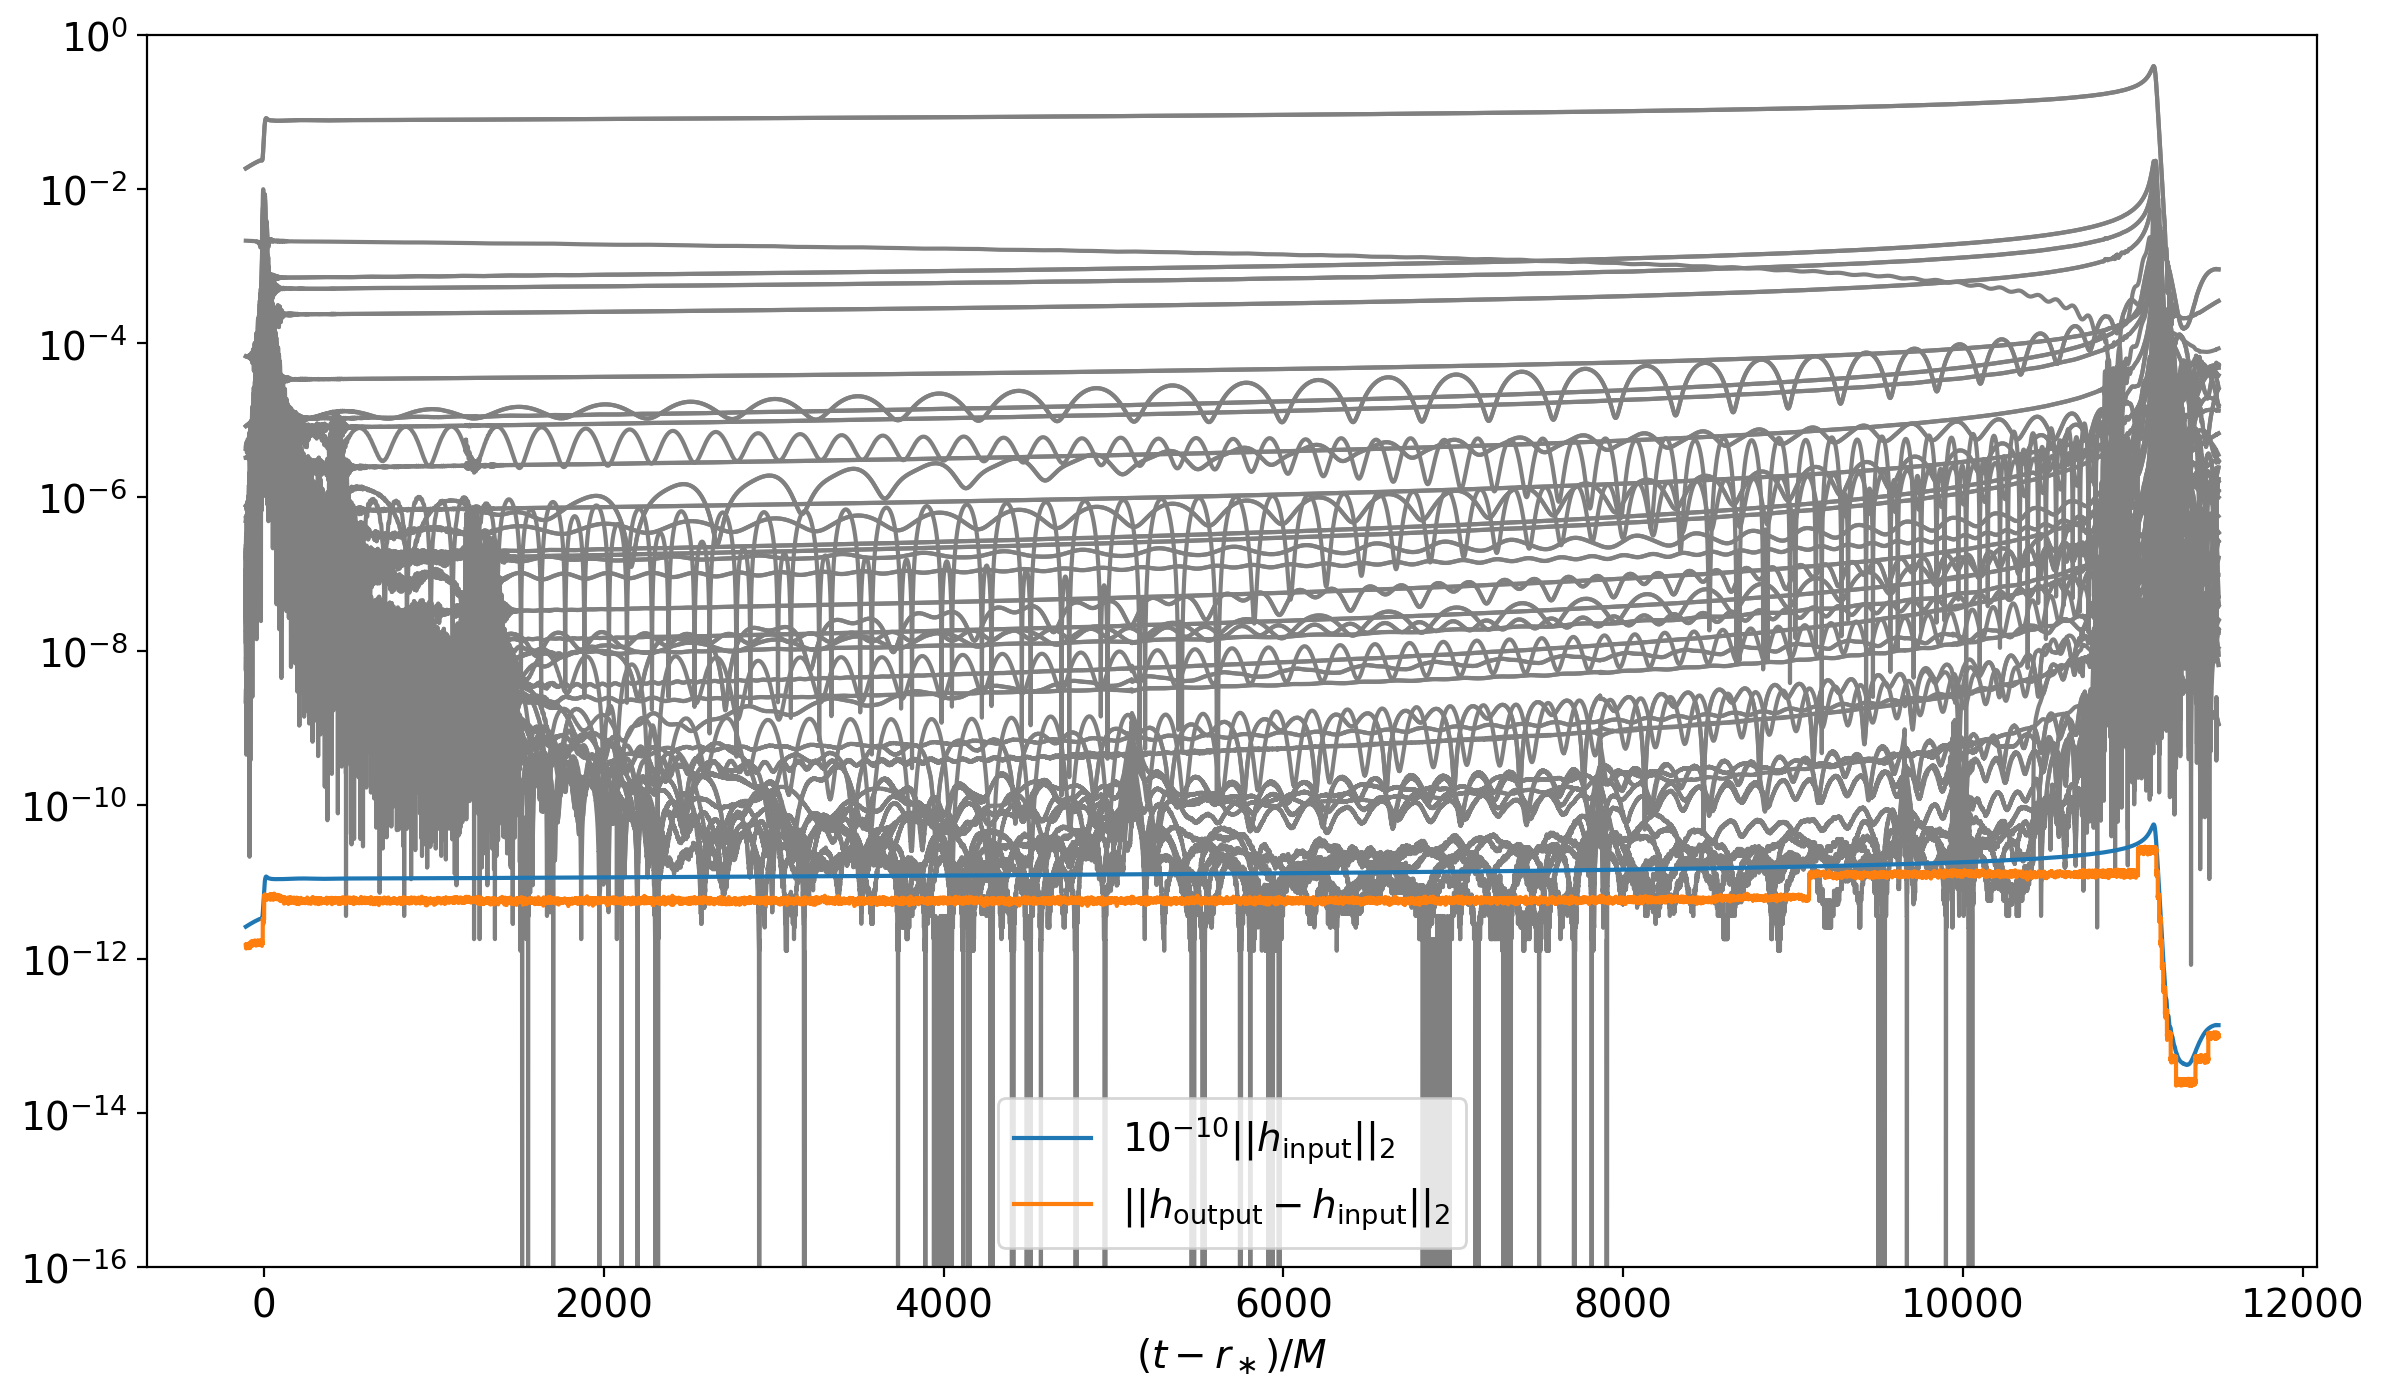

# Add 0.0

* Before truncation, many modes were small and noisy
* Signs were basically random
* After truncation, they are now $\pm 0.0$
* The sign doesn't matter, but flips randomly, thus not compressing well
* Get rid of it by adding 0.0

# XOR with previous time step

* Bitwise difference between data at successive times
* For ~smooth data, we are left with few bits changing
* This compresses *very* well
* It's trivial to do, and to undo:

# Shuffle

* Bytes of similar significance more correlated than consecutive bytes
* Store bytes of given significance consecutively

In [5]:
for n in np.random.rand(8): print(f"{n.view(np.uint64):064b}\n")

0011111111010111011110101111000001100101001000010001000011110010

0011111111011000011100100100011101111111110100111010110100000100

0011111111010000001001011010100110110110010011010100010100011000

0011111101010000011011000011000101001101110010111011110000000000

0011111111010110101000011110111001110101100110100001110001011000

0011111111101100110101111100001111110011101110110001111111111100

0011111111100100111001111100110110110101000110011111111010001011

0011111111100000111001001101010101010010110101000000001011100101



# Format

* Corotating frame
* Paired modes
* Truncate
* XOR
* Multishuffle
* Bzip2

Are you scared yet?

# Changing to a new format

* Pros:
  * Significant reduction in size
  * ~No cost to add insignificant modes
  * Easier for maintainers
  * Easier for users

* Cons:
  * Different is bad

# Solve the problem with code

* `GWFrames` — old and ugly
* `scri` - powerful but complicated
* `sxs` - new and beautiful